# Description
This will focus on using classic regression models and bayesian models. 

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [17]:
! pip install vapeplot sklearn stan_utility pyarrow fastparquet

     |████████████████████████████████| 17.3 MB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 28.6 MB 52.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 24.6 MB 55.2 MB/s eta 0:00:01
  Created wheel for fastparquet: filename=fastparquet-0.4.1-cp38-cp38-linux_x86_64.whl size=7152700 sha256=af96d7765ea088791d91adbf2d9d9dbb13192ff6d7de88ef607d224c09b81bb5
  Stored in directory: /home/jovyan/.cache/pip/wheels/bd/9a/95/3fbcf7e8b3f379ca499c994b956208d91778b1b1bb39c9208d
  Created wheel for thrift: filename=thrift-0.13.0-cp38-cp38-linux_x86_64.whl size=413780 sha256=4696835002b469f6bc7c78b52d2e0a4ec3b1ed40c60b6ff5cf60c296cf648e1e
  Stored in directory: /home/jovyan/.cache/pip/wheels/0a/52/7e/8054b57725b8f2b9ddbaacb81b271b939681cc03f8231e6ebc
Successfully built fastparquet thrift


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    base_path = r'/content/gdrive/My Drive/data_sci/colab/ski/'
    os.chdir(base_path)
    try:
        ! git clone https://github.com/chrisoyer/ski-snow-modeling/
    except:  # if dir not empty e.g. already cloned
        pass
    mod_path = os.path.join(base_path, 
                            r"ski-snow-modeling/src/analysis/project_utils/project_utils.py")
    import importlib.util
    spec = importlib.util.spec_from_file_location(name="utils.name", location=mod_path)
    utils = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(utils)
    
    os.chdir('./ski-snow-modeling/')
    # Change the working directory to the repo root.
    # Add the repo root to the Python path.
    import sys
    sys.path.append(os.getcwd())
else:
    # local running
    import project_utils as utils

In [26]:
# data wrangling
import numpy as np
import pandas as pd
import os.path
import pickle
import calendar

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import vapeplot
import arviz as az

# modeling
import pystan
import stan_utility

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters

In [6]:
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [15]:
file_path = r'../../data/snow_data_clean.parquet'
all_data_path = os.path.join(os.getcwd(), file_path)
model_path = r'./stan_model.pkl'
result_path = r'../../data/processed/stan_results.pkl'

In [20]:
# parquet opening is broken on colab
with open(file_path, 'rb') as parq_file:
    long_series_df = pd.read_parquet(parq_file)
assert long_series_df.base.isna().sum()==0

long_series_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region,pseudo_ts_delt,pseudo_ski_yr,pseudo_ts,basecol_interpolated
11085,137.0,2016-01-10,0.000000,Mt. Holiday,2.0,5.0,michigan,Other,324.0,-31.0,1692-01-10,True
11086,138.0,2016-01-11,-2.320142,Mt. Holiday,3.0,5.0,michigan,Other,324.0,-31.0,1692-01-11,True
11087,139.0,2016-01-12,-2.320142,Mt. Holiday,5.0,5.0,michigan,Other,324.0,-31.0,1692-01-12,True
11088,140.0,2016-01-13,6.737995,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-13,False
11089,141.0,2016-01-14,10.000000,Mt. Holiday,0.0,5.0,michigan,Other,324.0,-31.0,1692-01-14,False


# Feature Engineering

In [21]:
def add_month(data: pd.DataFrame) -> pd.DataFrame:
    return data.assign(month=lambda x:
                       x.pseudo_ts.dt.month)

def add_diff(data: pd.DataFrame) -> pd.DataFrame:
    """ use difference in base, not absolute value """
    return (data
            .assign(delta_base=lambda x: x.base.diff(1))
            .fillna(0)
            .drop(columns=['base'])
           )

def ohe(data: pd.DataFrame, col: str) -> pd.DataFrame:
    return pd.concat([data.drop(columns=[col]),
                      pd.get_dummies(data[col],
                                     prefix=col)],
                     axis=1)

def add_month_x_snowfall(data: pd.DataFrame) -> pd.DataFrame:
    """adds interaction terms"""
    months = [col for col in data.columns
              if 'month_' in col]
    combos_df = pd.concat([pd.Series(data.snowfall * data[month],
                                     name='snowfall_x_' + month)
                           for month in months], axis=1)
    return pd.concat([data, combos_df], axis=1)

def cleaner(data: pd.DataFrame, includes: list=[None]) -> pd.DataFrame:
    """ Removes interpolated rows and unneeded columns
    Params:
        data: df to operate on
        includes: column names NOT to drop (don't need to specify usually)
    ski_yr is needed for test/train split"""
    data = data.query('basecol_interpolated==False')
    bad_cols = ['dayofyr', 'station', 'state', 'pseudo_ski_yr',
                'timestamp', 'basecol_interpolated', 'pseudo_ts',
                'pseudo_ts_delt'
               ]
    bad_cols = [col for col in bad_cols if col not in includes]
    return data.drop(columns=bad_cols)

In [22]:
data = (long_series_df.pipe(add_month)
        .pipe(add_diff)
        .pipe(ohe, 'month')
        .pipe(add_month_x_snowfall)
        .pipe(cleaner)
)
data.head()

,snowfall,ski_yr,region,delta_base,month_1,month_2,month_3,month_4,month_5,month_6,...,snowfall_x_month_3,snowfall_x_month_4,snowfall_x_month_5,snowfall_x_month_6,snowfall_x_month_7,snowfall_x_month_8,snowfall_x_month_9,snowfall_x_month_10,snowfall_x_month_11,snowfall_x_month_12
11088,0.0,5.0,Other,9.058137,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11089,0.0,5.0,Other,3.262005,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11090,0.0,5.0,Other,0.000000,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11091,0.0,5.0,Other,0.000000,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11092,0.0,5.0,Other,0.000000,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bayesian Model in Stan (MCMC)
I want to add priors to the model that snowfall should only result in increases in base depth, and monthly effects should only result in reduction (i.e., monthly effect should measure strength of melting.); changes at odds with this should be considered as noise. A bayesian model allows for this.

In [24]:
stan_df = (long_series_df
           .pipe(add_month)
           .pipe(add_diff)
           .pipe(ohe, 'region')
           .pipe(ohe, 'month')
           .pipe(cleaner)
           )

In [35]:
# sample data; half million records => slow mcmc
stan_sample_full_df = (stan_df
                       .sample(frac=.16, axis=0, replace=False))

stan_sample_df = stan_sample_full_df.sample(frac=.25, axis=0)
stan_sample_test_df = stan_sample_full_df.drop(index=stan_sample_df.index)

# provide data including shapes and column type locations to stan
columns = stan_df.columns
region_cols = [c for c in columns if "region" in c]
month_cols = [col for col in stan_sample_df.columns if "month" in col]

X = stan_sample_df.drop(columns=['delta_base'])
X_month= X[month_cols]
X_snow = X['snowfall']
X_region = X[region_cols]
y = stan_sample_df[['delta_base']]

X_test = stan_sample_test_df.drop(columns=['delta_base'])
X_month_test = X_test[month_cols]
X_snow_test = X_test['snowfall']
X_region_test = X_test[region_cols]
y_test = stan_sample_test_df[['delta_base']]

stan_data = {'N': X.shape[0],
             'K_month': X_month.shape[1],
             'X_month': X_month.to_numpy(),
             'K_reg': X_region.shape[1],
             'X_reg': X_region.to_numpy(),
             'X_snow': X_snow.to_numpy().reshape(-1,1),
             'y': y.to_numpy().reshape(-1),
             # test
             'N_test': X_test.shape[0],
             'X_month_test': X_month_test.to_numpy(),
             'X_reg_test': X_region_test.to_numpy(),
             'X_snow_test': X_snow_test.to_numpy().reshape(-1,1),
             }

In [67]:
stan_data['K_month']

12

In [75]:
stan_model_str = """
functions {}
data {
    // input data passed from Python
    int<lower=1> N;               // number of data observations
    int<lower=1> K_month;         // no of melting predictor
    matrix[N, K_month] X_month;   // predictor for melting features
    int<lower=1> K_reg;           // no of region features
    matrix[N, K_reg] X_reg;       // region predictors
    matrix[N, 1] X_snow;          // snowfall predictor
    vector[N] y;                  // response vector
    
    // test variables
    int<lower=1> N_test;                  // no of test records
    matrix[N_test, K_month] X_month_test; // predictor for melting features
    matrix[N_test, K_reg] X_reg_test;     // region predictors
    matrix[N_test, 1] X_snow_test;
}
transformed data {
    matrix[N, K_reg] X_reg_snow;
    row_vector[N] X_snow_rvect = to_row_vector(X_snow);
    matrix[N_test, K_reg] X_reg_snow_test;
    row_vector[N_test] X_snow_rvect_test = to_row_vector(X_snow_test);
    
    for (k in 1:K_reg) {          //  K_regxN * Nx1  T
        for (n in 1:N) {
            X_reg_snow[n,k] = X_snow_rvect[n] * X_reg[n,k];
    }  }
    
    // same, but for test. Should do this with a function...
    for (k in 1:K_reg) {
        for (n in 1:N_test) {
            X_reg_snow_test[n,k] = X_snow_rvect_test[n] * X_reg_test[n,k];
    }  }
}
parameters {
    // intercept was causing divergences and coef interpretation 
    // makes more sense without intercept: 
    // I don't expect change in base depth absent melting or snowfall
    vector<upper=0>[K_month] beta_mo;           // coefficients for melting
    vector<lower=0, upper=1>[K_reg] beta_reg_snow;       // coef for region x snow interaction
    real<lower=0> sigma;                        // must be +ve
    real<lower=0> sig_mos;                      // must be +ve
}
transformed parameters {
    vector[N] mu;                       // y_hat
    mu = X_month*beta_mo + X_reg_snow*beta_reg_snow;
}
model {
    sigma ~ cauchy(0, 10);              // half Cauchy
    sig_mos ~ cauchy(0, 20);
    for (n in 1:K_month) {
        beta_mo[n] ~ normal(0, sig_mos) T[,0]; // sample from normal, only -ve
    }
    // prior on snow columns is beta over [0,1]
    beta_reg_snow ~ beta(2.2, 3);         // reparameterize so this and snow are from beta dist
    y ~ normal(mu, sigma);
}
generated quantities{
    vector[N_test] y_test;
    //for(n in 1:N_test) {
        y_test = normal_rng(X_month_test[n]*beta_mo + 
                               X_reg_snow_test[n]*beta_reg_snow, sigma);
  //}
}
"""

In [76]:
sm = pystan.StanModel(model_code=stan_model_str, model_name='stan_model')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL stan_model_7bd6eeaf34107d15f99f3d6c05bc919b NOW.


KeyboardInterrupt: 

In [ ]:
# avoid recompile if possible
with open(model_path, 'wb') as f:
    pickle.dump(sm, f)

In [ ]:
fit = sm.sampling(data=stan_data, iter=2_000, chains=4, n_jobs=-1,
                  control={'adapt_delta': 0.80, # p accepting posterior draw
                           'stepsize': .1,}, 
                  seed=42, verbose=True)

In [ ]:
fit

In [ ]:
# for overnight run
try:
    fit
except NameError:
    with open(model_path, 'rb') as f:
        sm = pickle.load(f)
    with open(result_path, 'rb') as f:
        fit = pickle.load(f)
else:
    with open(result_path, 'wb') as f:
        pickle.dump(fit, f)

## MCMC Diagnostics
We will want to check:
1. Model actually runs.
1. Good Mixing of Chains: (fix with stronger prior, reparameterization)
    1. $\hat{R}$ is 1.1 or under for all parameters.
    1. When n_eff / n_transitions < 0.001 the estimators that we use are often biased and can significantly overestimate the true effective sample size.
1. Check tree depth:
if threshold saturated, increase tree depth _control={max_treedepth: 15}_
1. 

_



In [17]:
stan_utility.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat looks reasonable for all parameters
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


In [18]:
# fix brackets in col nmaes
fit_df = (fit.to_dataframe()
          .rename(columns=lambda x: x.replace("[", "_"))
          .rename(columns=lambda x: x.replace("]", "")))

fit_df.head()

,chain,draw,warmup,beta_mo_1,beta_mo_2,beta_mo_3,beta_mo_4,beta_mo_5,beta_mo_6,beta_mo_7,beta_mo_8,beta_mo_9,beta_mo_10,beta_mo_11,beta_mo_12,beta_reg_snow_1,beta_reg_snow_2,beta_reg_snow_3,beta_reg_snow_4,beta_reg_snow_5,beta_reg_snow_6,beta_reg_snow_7,beta_reg_snow_8,sigma,sig_mos,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-0.010823,-0.001414,-0.155945,-0.358696,-0.688555,-1.039558,-0.253527,-0.637661,-0.648517,-0.185452,-0.017981,-0.003156,0.126888,0.027550,0.089822,0.060999,0.128948,0.104783,0.093946,0.035513,2.669763,0.732536,-31458.900792,0.954845,0.201714,4,15,0,31480.910231
1,0,1,0,-0.002925,-0.000986,-0.104451,-0.291824,-0.755492,-0.781327,-0.028368,-0.038773,-1.001193,-0.687548,-0.027469,-0.004354,0.131466,0.034077,0.099342,0.061575,0.137310,0.113937,0.089328,0.020252,2.667566,0.542573,-31464.745678,0.818891,0.201714,4,15,0,31474.859048
2,0,2,0,-0.004076,-0.001218,-0.126537,-0.274506,-0.710576,-1.785649,-0.009700,-0.074646,-0.768187,-0.404607,-0.020173,-0.003389,0.135424,0.047011,0.104897,0.051523,0.115628,0.122511,0.089579,0.030260,2.669758,0.520178,-31463.109891,0.769596,0.201714,4,31,0,31475.663783
3,0,3,0,-0.010541,-0.001527,-0.156079,-0.317546,-0.518700,-1.372306,-0.102805,-0.007371,-0.367052,-0.443986,-0.005426,-0.017733,0.128840,0.044146,0.096656,0.046977,0.096151,0.114337,0.084004,0.019040,2.683190,0.683299,-31468.604855,0.762052,0.201714,4,15,0,31476.248846
4,0,4,0,-0.001054,-0.001183,-0.104080,-0.314959,-0.489809,-0.867441,-0.644221,-0.000768,-0.671171,-0.352853,-0.058616,-0.001189,0.122299,0.035783,0.097441,0.036432,0.072999,0.132411,0.065851,0.033414,2.678463,0.473755,-31472.430687,0.988330,0.201714,4,15,0,31482.581390


## Visualization of results

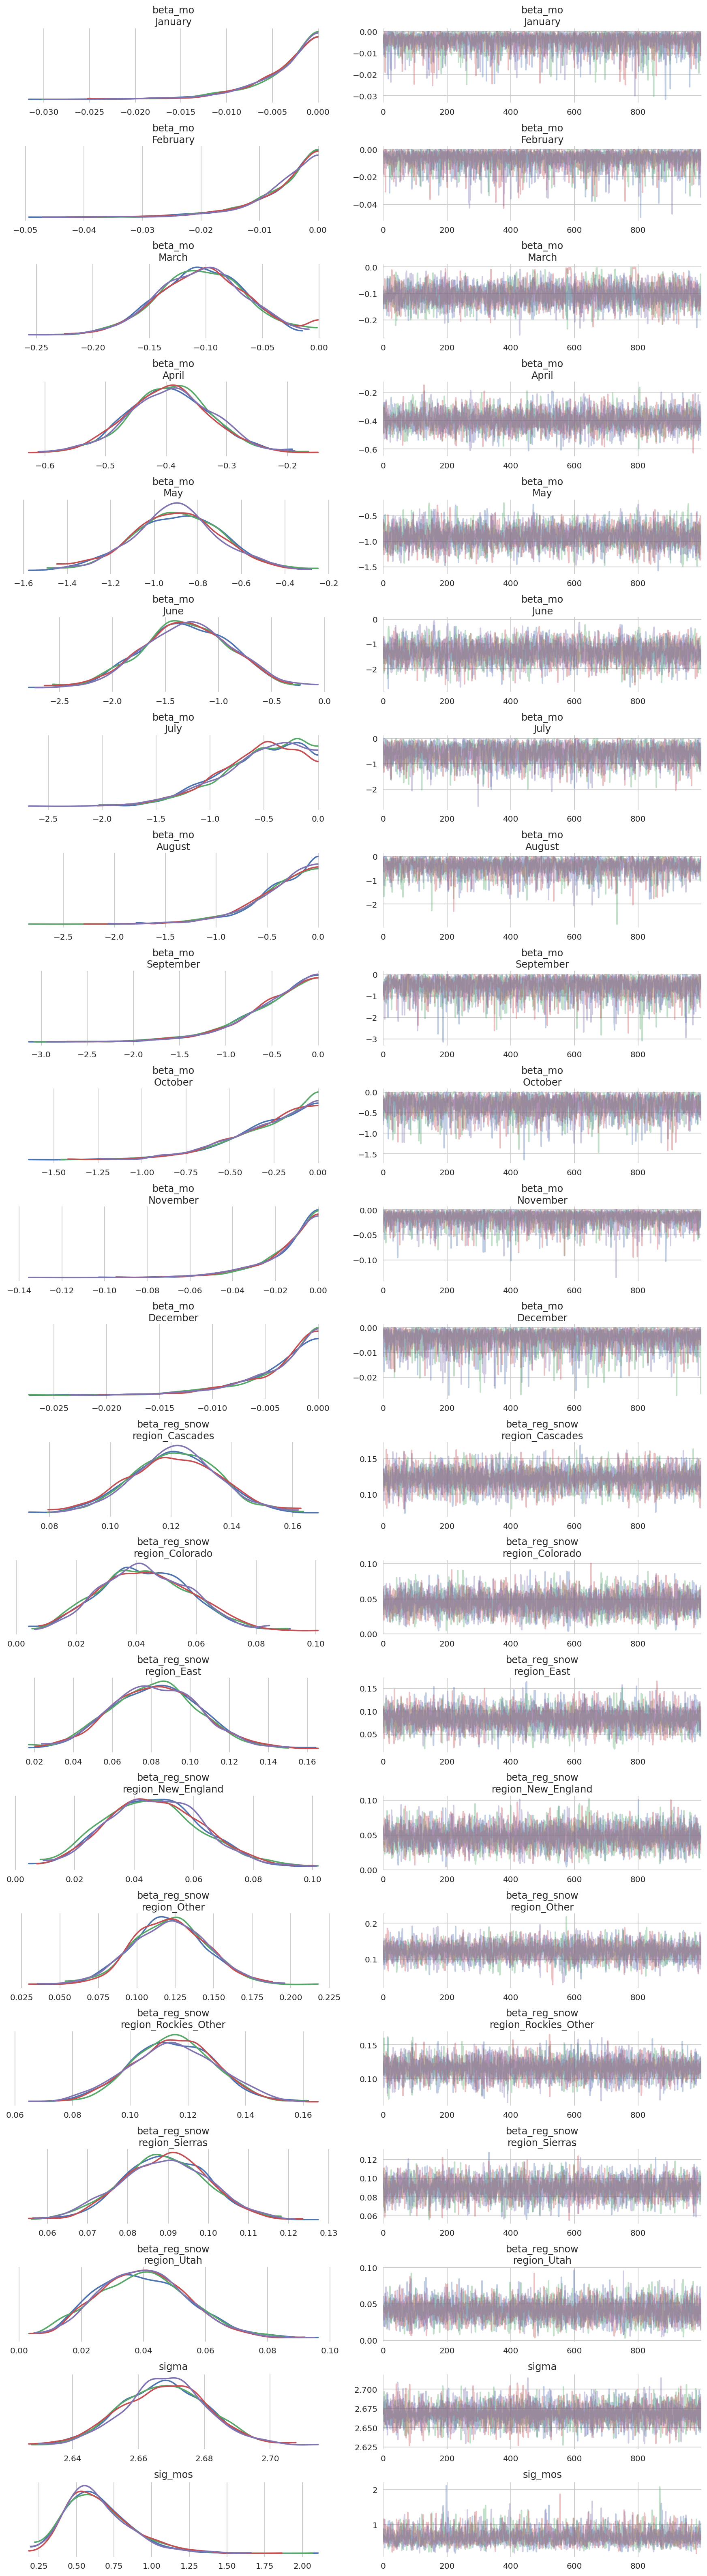

In [ ]:
fit_az = az.from_pystan(posterior=fit,
                        dims={'beta_reg_snow': ['Coefficients_for_Snow_by_Region'],
                              'beta_mo': ['Melting_Coefficients_by_Month']},
                        coords={'Coefficients_for_Snow_by_Region': X_region.columns.values.tolist(),
                                'Melting_Coefficients_by_Month': [calendar.month_name[i+1] for i in range(12)]}
                        )
rc = {'plot.max_subplots': None}
az.rcParams.update(rc)
sns.set_style('whitegrid')
az.plot_trace(fit_az)

In [92]:
# get region names without "region_"
region_names = [reg[7:] for reg in X_region.columns.values.tolist()]

region_betas_df = fit_df.filter(regex="reg", axis=1)
reg_cols = region_betas_df.columns
region_betas_df = (region_betas_df
                   .rename(columns={col: reg_name for col, reg_name 
                                    in zip(reg_cols, region_names)})
                   .melt(var_name="region"))
region_betas_df.head(2)

,region,value
0,Cascades,0.126888
1,Cascades,0.131466


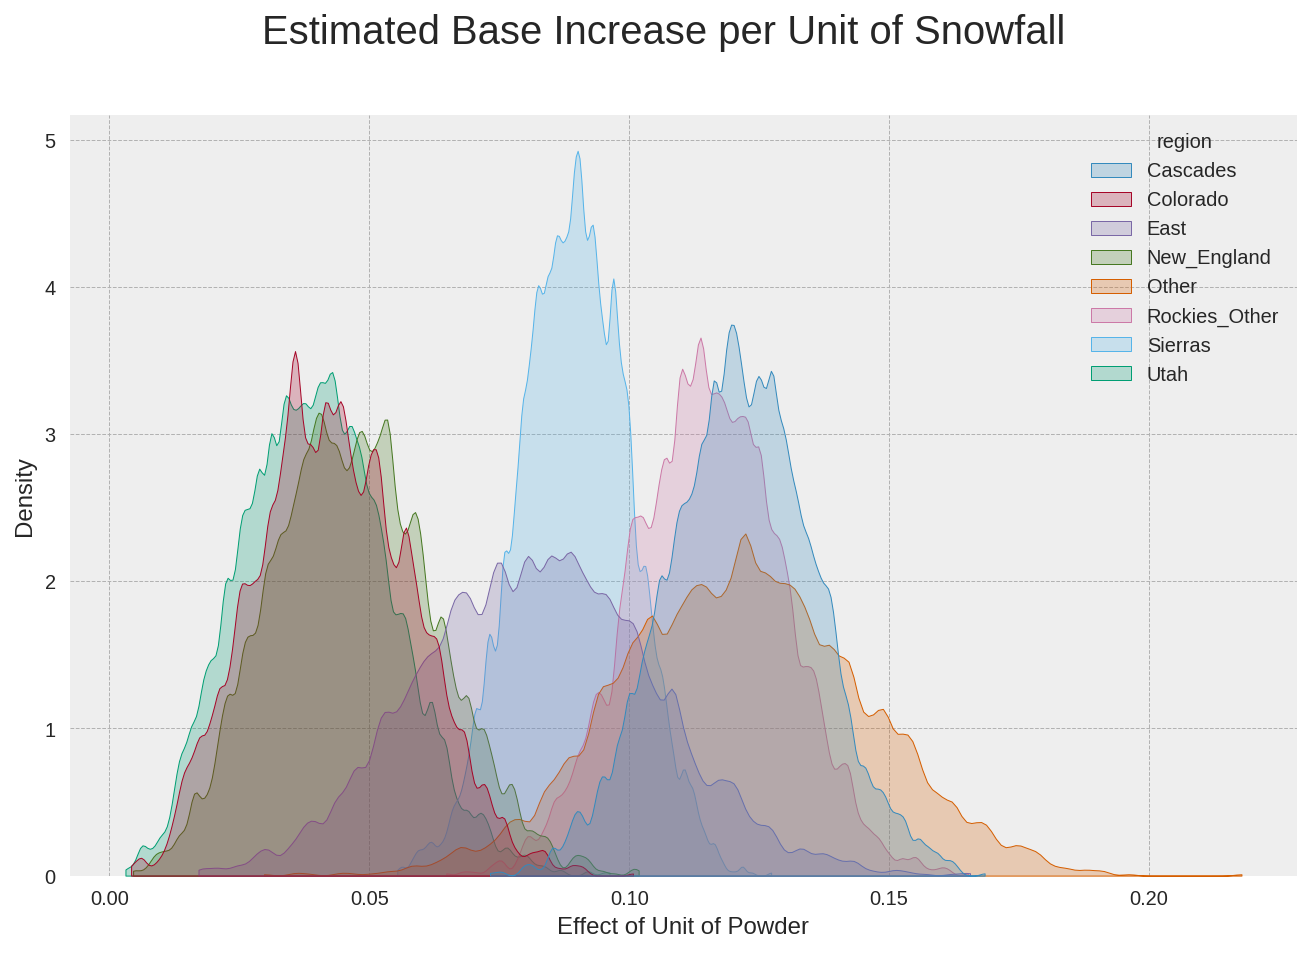

In [93]:
plt.style.use('bmh')
fig = sns.kdeplot(x=region_betas_df.value, hue=region_betas_df.region, fill=True, cut=0, bw_adjust=.3)
plt.suptitle("Estimated Base Increase per Unit of Snowfall", fontsize=20)
plt.xlabel("Effect of Unit of Powder");

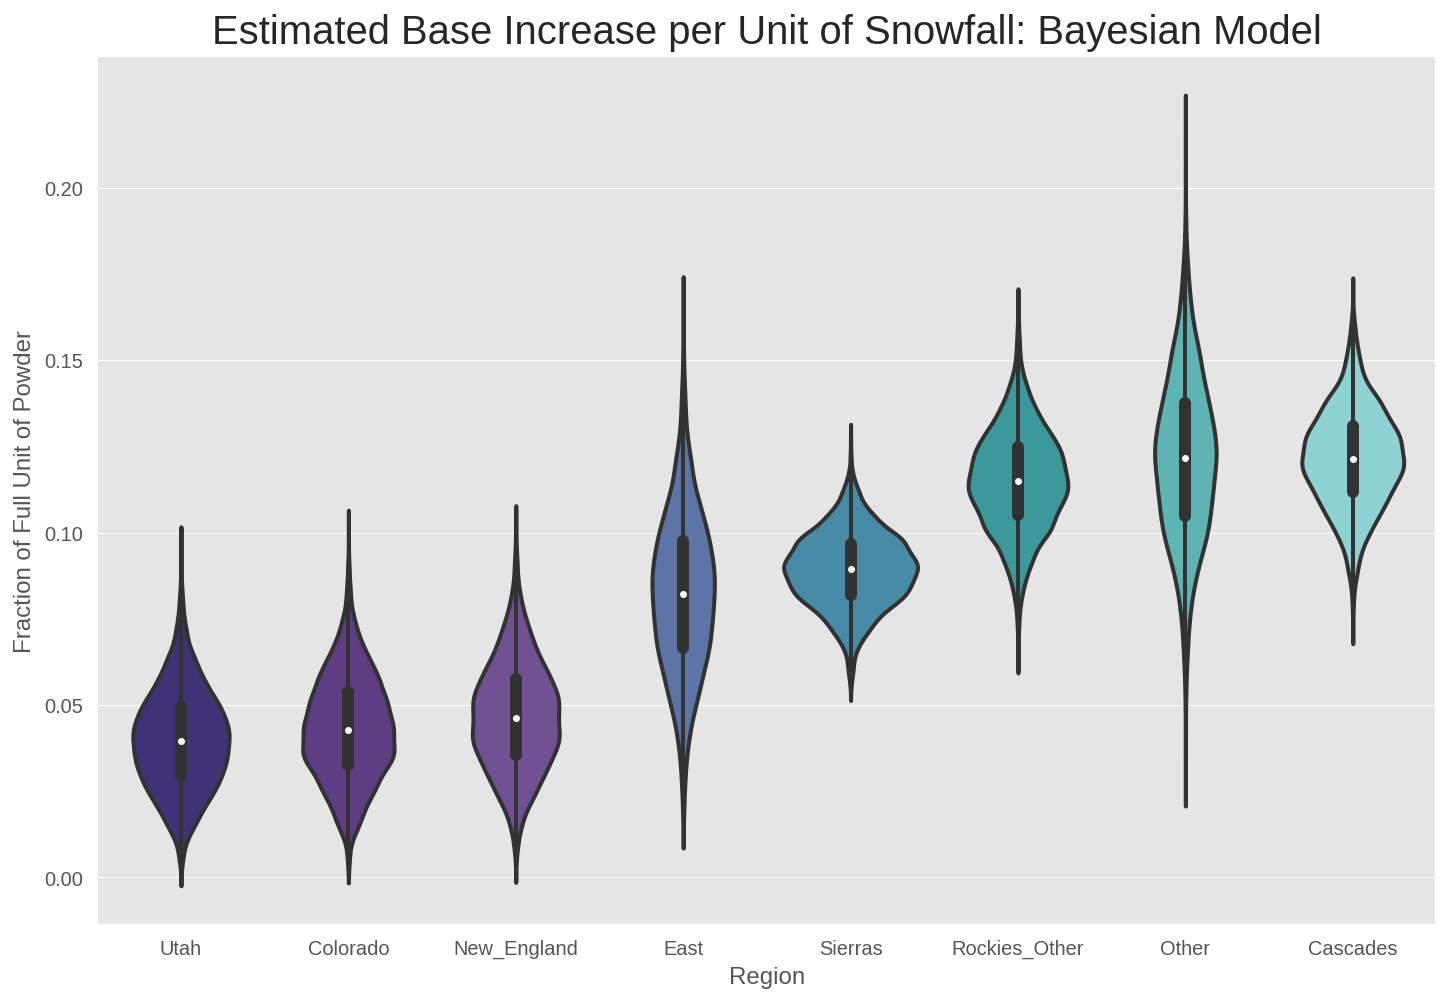

In [119]:
plt.style.use('ggplot')
jazzcup = sns.blend_palette(vapeplot.palette("jazzcup"), n_colors=region_betas_df.region.unique().size)
f, ax = plt.subplots(figsize=(12, 8))
sort_order = region_betas_df.groupby(['region']).mean().sort_values(by='value', ascending=True).index

sns.violinplot(x='region', y='value', data=region_betas_df,
            order=sort_order, palette=jazzcup)

plt.title("Estimated Base Increase per Unit of Snowfall: Bayesian Model", fontsize=20)
plt.xlabel('Region')
plt.ylabel('Fraction of Full Unit of Powder');

In [210]:
month_betas_df = fit_df.filter(like='beta_mo').melt(var_name="month")
month_betas_df = month_betas_df[month_betas_df.value > month_betas_df.value.quantile(.02)]
month_map = {f"beta_mo_{i}": calendar.month_abbr[i] for i in range(1, 13)}
#month_betas_df['month'] = pd.to_datetime(month_betas_df['month'].replace(month_map), format="%B").dt.month.astype('category')
month_betas_df['month'] = month_betas_df['month'].replace(month_map).astype('str')
month_betas_df.head()

,month,value
0,Jan,-0.010823
1,Jan,-0.002925
2,Jan,-0.004076
3,Jan,-0.010541
4,Jan,-0.001054


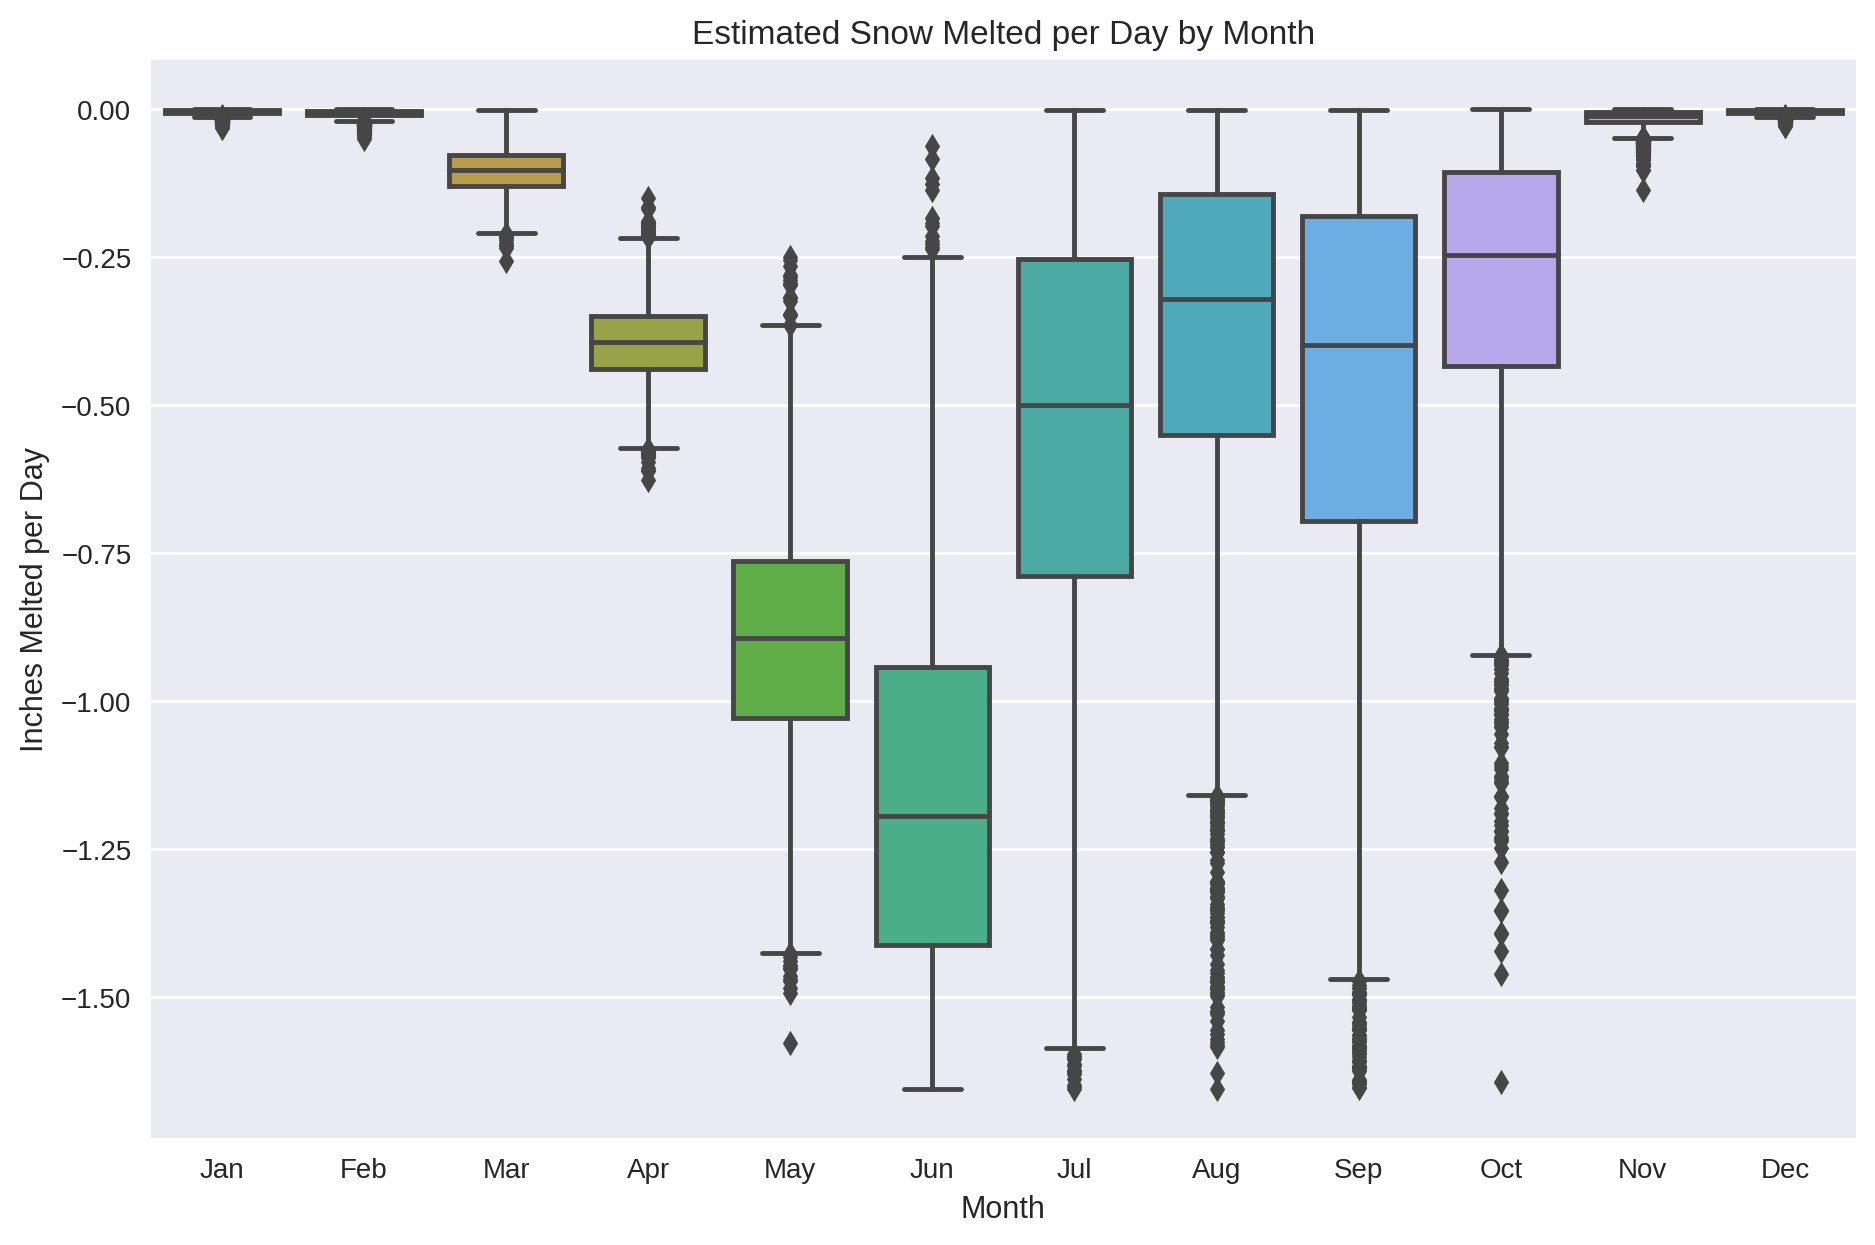

In [230]:
def plot_snow_betas(df, start_mo):
    fig, ax = plt.subplots()
    month_ordered = [mo for mo in calendar.month_abbr[1:] if mo in df.month.unique()]
    start_mo_ix = month_ordered.index(start_mo)
    month_ordered = month_ordered[start_mo_ix:] + month_ordered[:start_mo_ix]
    sns.boxplot(data=df, y='value', x='month', order=month_ordered,
                ax=ax, )
    ax.set_ylabel('Inches Melted per Day')
    ax.set_xlabel('Month')
    ax.set_title('Estimated Snow Melted per Day by Month');
plot_snow_betas(month_betas_df, "Jan")

These estimates are mostly expected, but there seems to be low melting amounts during summer...this can be explained when we realize that most of the values for May-November were interpolated. The averages aren't weighted by ski acreage, so the large number of small ski stations on the east coast & midwest with short seasons are disproportionately affecting these numbers. 

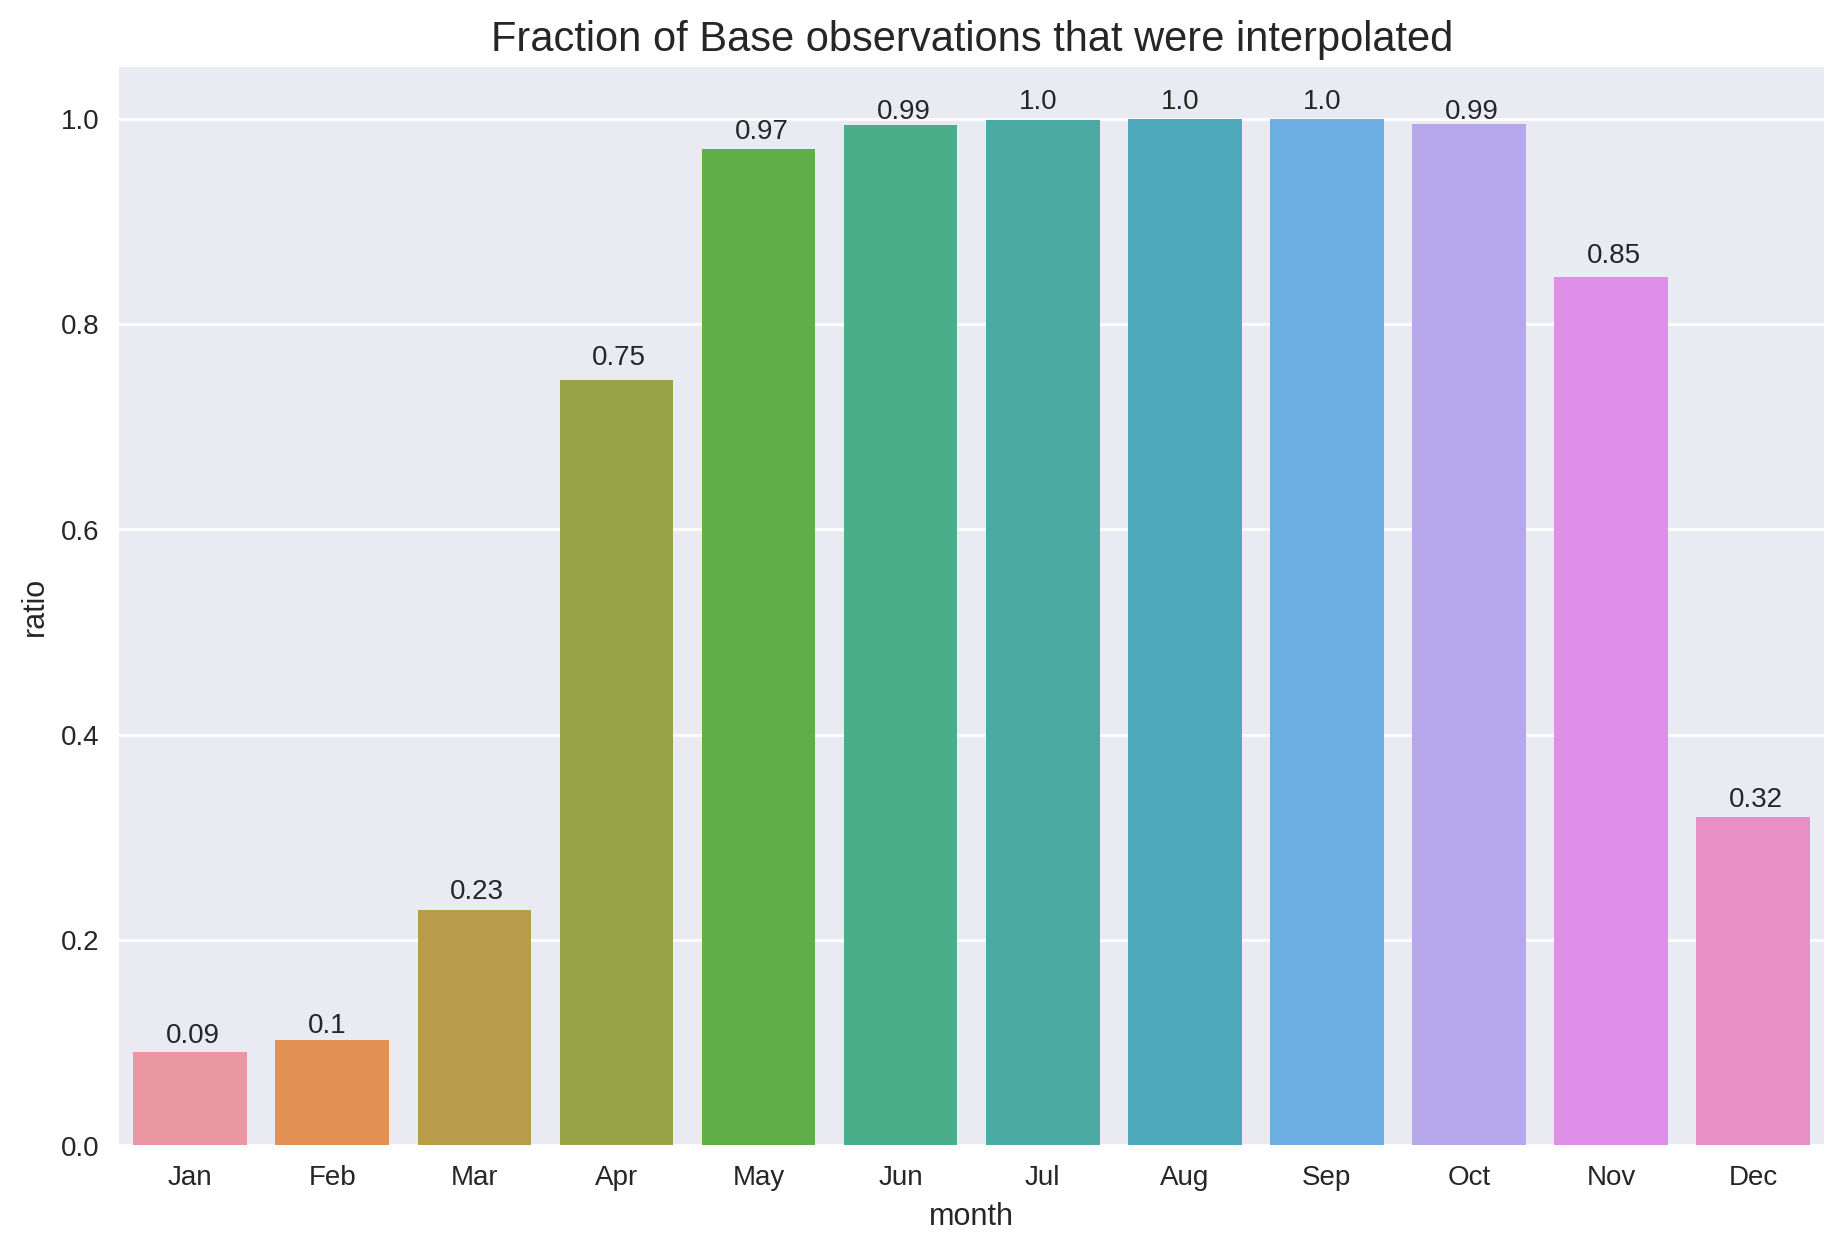

In [208]:
interpo_ratios=(long_series_df
    .assign(month=lambda x: x.pseudo_ts.dt.month)
    .groupby('month')
    .apply(lambda x: x.basecol_interpolated.sum()/x.shape[0])
    .to_frame()
    .reset_index()
    .rename(columns={0:'ratio'})
)
fig, ax = plt.subplots()
sns.barplot(data=interpo_ratios, x='month', y='ratio', ax=ax)
plt.title('Fraction of Base observations that were interpolated', fontsize=15)
[plt.text((i-.17), value+.01, str(value)) for i, value in enumerate(interpo_ratios.ratio.round(2).to_numpy())]
months_xticks(ax);

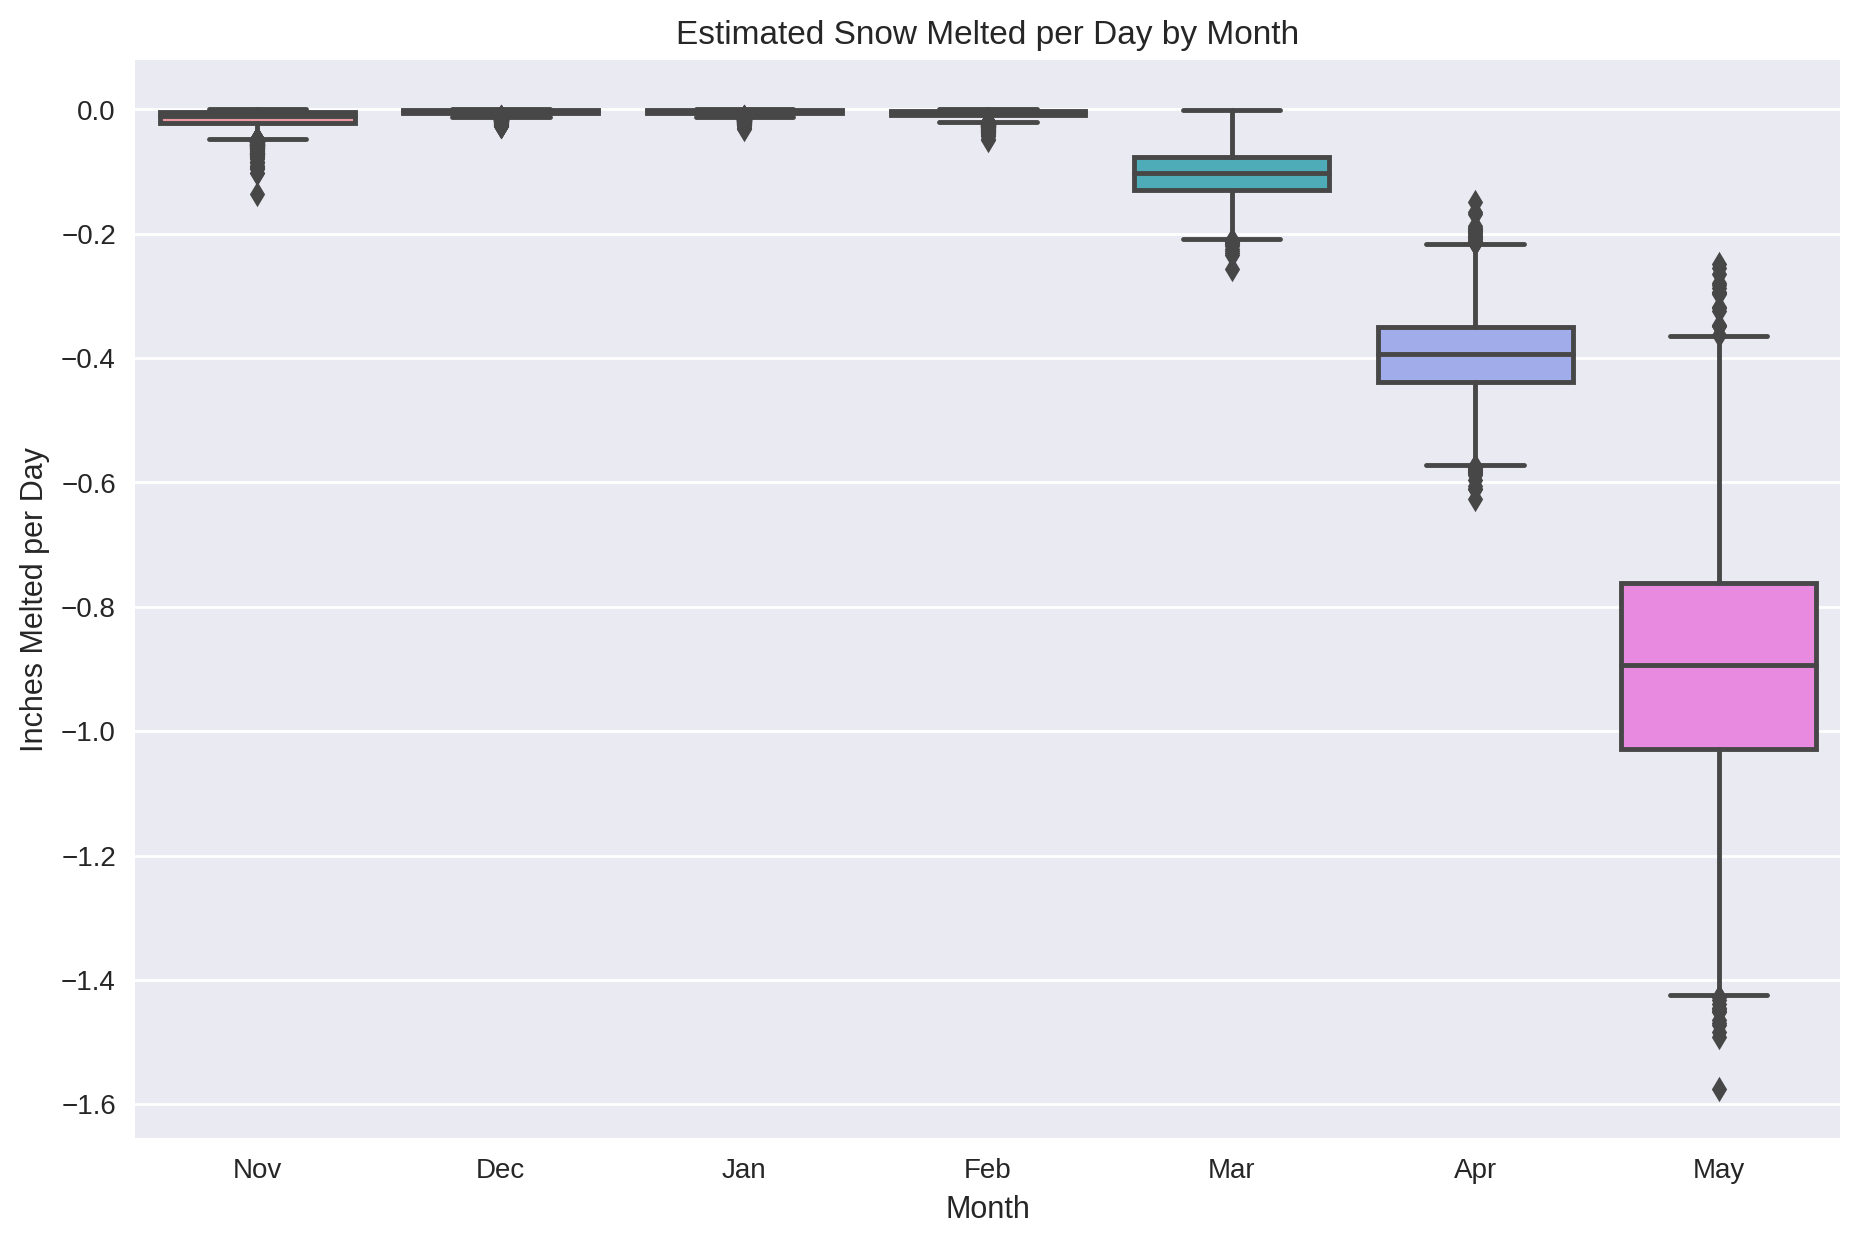

In [232]:
plot_snow_betas(month_betas_df[~month_betas_df.month.isin(['Jun', 'Jul', 'Aug', 'Sep', 'Oct'])], "Nov")